# Acceso de las API

## Acceso del API de Spotify

Primero generamos un token para usara dicho api uasando el client_id y el client_secret

In [115]:
import requests
import json
import base64

def get_token(client_id, client_secret):
    auth_str = client_id + ":" + client_secret
    auth_bytes = auth_str.encode("utf-8")

    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = requests.post(url=url, headers=headers, data=data)
    json_result = json.loads(result.content)
    return json_result['access_token']
client_id = "489e275b8c0a4fe78c837086f353fa61"
client_secret = "5df4bb102e2a41349cbf064fc9f4edd9"
# Obtener el token de acceso
token = get_token(client_id, client_secret)
token

'BQDOh-3hZBKwXG45VaNYE5j74ruWPH5glcU-Xj45wl7NFZqec3s_Agzm9pBUPUSGBVjNvqSFfLr5M11ZiSA_3UXPPi8V5XqCX1_tsrXsghWBSNxjaCU'

# Aplicación de las API

## Api Spotify

### Buscar artistas

In [86]:
def search_for_artist(token, artist_name):
    url = "https://api.spotify.com/v1/search"
    headers = {
        "Authorization": "Bearer " + token,
        "Content-Type": "application/json"
    }
    query = {'q': artist_name, 'type': 'artist', 'limit': 1}
    result = requests.get(url, headers=headers, params=query)
    json_result = result.json()
    return json_result

In [98]:
artist_name = "Maluma"
result = search_for_artist(token, artist_name)
print(result)

{'error': {'status': 401, 'message': 'Invalid access token'}}


In [88]:
import requests

def buscar_playlist(token, nombre_playlist):
    """
    Busca playlists en Spotify por nombre.

    Parámetros:
    - token (str): Token de acceso para la API de Spotify. Debe ser un token válido obtenido mediante el proceso de autenticación de la API.
    - nombre_playlist (str): El nombre o parte del nombre de la playlist que se desea buscar.

    Retorna:
    - list: Una lista de diccionarios, donde cada diccionario contiene el 'nombre' y la 'url' de una playlist encontrada.
      Retorna None si la solicitud no fue exitosa.

    La función realiza una solicitud GET al endpoint de búsqueda de la API de Spotify, utilizando el token de acceso para la autorización.
    Se buscan playlists que coincidan con el término proporcionado en 'nombre_playlist'. La búsqueda está limitada a los primeros 10 resultados por defecto,
    pero este valor puede ser ajustado.
    """
    url = "https://api.spotify.com/v1/search"
    headers = {"Authorization": f"Bearer {token}"}
    params = {"q": nombre_playlist, "type": "playlist", "limit": 10}  # Puedes ajustar el límite según necesites

    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        playlists = response.json()['playlists']['items']
        return [{"nombre": playlist['name'], "url": playlist['external_urls']['spotify']} for playlist in playlists]
    else:
        return None

# Ejemplo de uso de la función
nombre_playlist = "This Is Luis Miguel"  # Ejemplo de término de búsqueda
playlists_encontradas = buscar_playlist(token, nombre_playlist)

if playlists_encontradas:
    for playlist in playlists_encontradas:
        print(f"Nombre: {playlist['nombre']}, URL: {playlist['url']}")
else:
    print("No se encontraron playlists.")

Nombre: This Is Luis Miguel, URL: https://open.spotify.com/playlist/37i9dQZF1DZ06evO1mfBM4
Nombre: LUIS MIGUEL MIX EXITOS/LO MEJOR, URL: https://open.spotify.com/playlist/6GtwpSTsT5oGRsVBI0pKty
Nombre: This Is Luis R Conriquez, URL: https://open.spotify.com/playlist/37i9dQZF1DZ06evO0aI7Qc
Nombre: This Is Luis Miguel Del Amargue, URL: https://open.spotify.com/playlist/37i9dQZF1DZ06evO0dpRWE
Nombre: Luis Miguel Mix, URL: https://open.spotify.com/playlist/37i9dQZF1EIXsXQ30glNSL
Nombre: This Is: Luis Miguel , URL: https://open.spotify.com/playlist/2coP6ONL969BOYoXVDaPZJ
Nombre: Luis Miguel: Romances, URL: https://open.spotify.com/playlist/37i9dQZF1DX894PYVoChlV
Nombre: This is Luis Miguel, URL: https://open.spotify.com/playlist/0iA9dfI1NoPqPjnFm2WEGj
Nombre: Luis Miguel: Ranchero, URL: https://open.spotify.com/playlist/37i9dQZF1DWYva3WHwOh0z
Nombre: This Is Luis Miguel, URL: https://open.spotify.com/playlist/57Y7xZA2FIyJQvdLcGKRTT


In [89]:
def obtener_detalles_playlist_completa_con_album(token, playlist_id):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}"
    headers = {"Authorization": f"Bearer {token}"}

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        playlist_details = response.json()
        detalles = {
            "nombre": playlist_details['name'],
            "descripcion": playlist_details.get('description', 'Sin descripción'),
            "total_canciones": playlist_details['tracks']['total'],
            "seguidores": playlist_details['followers']['total'],
            "imagenes": [imagen['url'] for imagen in playlist_details['images']],
            "canciones": [
                {
                    "nombre": item['track']['name'],
                    "artista": ", ".join([artist['name'] for artist in item['track']['artists']]),
                    "duracion_ms": item['track']['duration_ms'],
                    "album": item['track']['album']['name']  # Incluir el nombre del álbum
                } for item in playlist_details['tracks']['items']
            ] if 'items' in playlist_details['tracks'] else []
        }
        return detalles
    else:
        return None

# Asumiendo que tienes el token de acceso y el ID de la playlist que te interesa
detalles_playlist = obtener_detalles_playlist_completa_con_album(token, "37i9dQZF1DZ06evO1mfBM4")

# Crear un DataFrame a partir de la lista de canciones
df_canciones = pd.DataFrame(detalles_playlist['canciones'])

# Agregar columnas con detalles generales de la playlist a cada fila
df_canciones['nombre_playlist'] = detalles_playlist['nombre']
df_canciones['descripcion_playlist'] = detalles_playlist['descripcion']
df_canciones['total_canciones_playlist'] = detalles_playlist['total_canciones']
df_canciones['seguidores_playlist'] = detalles_playlist['seguidores']

# Guardar el DataFrame en un archivo CSV
nombre_archivo_csv = "detalles_playlist_con_album.csv"
df_canciones.to_csv(nombre_archivo_csv, index=False)

print(f"Detalles de la playlist, incluyendo el álbum de cada canción, guardados en '{nombre_archivo_csv}'")

Detalles de la playlist, incluyendo el álbum de cada canción, guardados en 'detalles_playlist_con_album.csv'


### Buscar canciones en Álbumes

In [109]:
import requests

def buscar_albumes_por_cancion(nombre_cancion, token):
	if not token:
		print("Token de acceso no proporcionado.")
		return None

	# URL de la API de búsqueda de Spotify
	url = "https://api.spotify.com/v1/search"
	
	# Parámetros de la búsqueda
	parametros = {
		"q": nombre_cancion,
		"type": "track",
		"limit": 10  # Ajusta este valor según sea necesario
	}
	
	# Headers con el token de autorización
	headers = {
		"Authorization": f"Bearer {token}"
	}
	
	# Realizar la solicitud a la API
	response = requests.get(url, headers=headers, params=parametros)
	
	# Verificar si la solicitud fue exitosa
	if response.status_code == 200:
		resultados = response.json()
		albumes = []
		
		# Extraer los álbumes de las pistas encontradas
		for track in resultados['tracks']['items']:
			album = track['album']
			albumes.append({
				"nombre_album": album['name'],
				"artista": ", ".join([artist['name'] for artist in album['artists']]),
				"fecha_lanzamiento": album['release_date'],
				"url_album": album['external_urls']['spotify']
			})
		
		return albumes
	else:
		print(f"Error en la solicitud: {response.status_code}")
		return None

# Ejemplo de uso
nombre_cancion = "Fría como el viento"
albumes = buscar_albumes_por_cancion(nombre_cancion, token)

if albumes:
	for album in albumes:
		print(f"Álbum: {album['nombre_album']}, Artista: {album['artista']}, Fecha de Lanzamiento: {album['fecha_lanzamiento']}, URL: {album['url_album']}")
else:
	print("No se encontraron álbumes para la canción proporcionada.")

Error en la solicitud: 401
No se encontraron álbumes para la canción proporcionada.


### Buscar Canciones en Playlists

In [91]:
import requests

def buscar_playlists_por_cancion(nombre_cancion, token):
	# URL de la API de búsqueda de Spotify
	url = f"https://api.spotify.com/v1/search"
	
	# Parámetros de la búsqueda
	parametros = {
		"q": nombre_cancion,
		"type": "playlist",
		"limit": 10  # Ajusta este valor según sea necesario
	}
	
	# Headers con el token de autorización
	headers = {
		"Authorization": f"Bearer {token}"
	}
	
	# Realizar la solicitud a la API
	response = requests.get(url, headers=headers, params=parametros)
	
	# Verificar si la solicitud fue exitosa
	if response.status_code == 200:
		resultados = response.json()
		playlists = []
		
		# Extraer las playlists encontradas
		for playlist in resultados['playlists']['items']:
			playlists.append({
				"nombre_playlist": playlist['name'],
				"descripcion": playlist['description'],
				"cantidad_canciones": playlist['tracks']['total'],
				"url_playlist": playlist['external_urls']['spotify']
			})
		
		return playlists
	else:
		return None

# Ejemplo de uso
nombre_cancion = "Here with me"
playlists = buscar_playlists_por_cancion(nombre_cancion, token)

if playlists:
	for playlist in playlists:
		print(f"Playlist: {playlist['nombre_playlist']}, Descripción: {playlist['descripcion']}, Cantidad de Canciones: {playlist['cantidad_canciones']}, URL: {playlist['url_playlist']}")
else:
	print("No se encontraron playlists para la canción proporcionada.")

Playlist: Here With Me 1 hour, Descripción: , Cantidad de Canciones: 15, URL: https://open.spotify.com/playlist/0OHM62OzIXILSqFTZnTNeS
Playlist: new nü, Descripción: nü-metal revival is happening here and now with Magnolia Park., Cantidad de Canciones: 50, URL: https://open.spotify.com/playlist/37i9dQZF1DX1k0OdTn3ZMX
Playlist: Here With Me, Descripción: , Cantidad de Canciones: 67, URL: https://open.spotify.com/playlist/31YGoILJ8YepX7scAmNrnt
Playlist: REAL COUNTRY, Descripción: Dm me on Instagram with song suggestions to add to here @pjeezy_15, Cantidad de Canciones: 159, URL: https://open.spotify.com/playlist/5Iqqg4Q7Y6gJxRk6HLxLUl
Playlist: Here with me 1 hour, Descripción: 1 hour of Here with me from d4vd, Cantidad de Canciones: 25, URL: https://open.spotify.com/playlist/2qv9JsKouogUEng6y2HIwB
Playlist: Here With Me (feat. CHVRCHES) – Marshmello (2), Descripción: , Cantidad de Canciones: 3, URL: https://open.spotify.com/playlist/4SSjpuco8wBJWbtx0nz452
Playlist: This Is Heavy Worshi

### Buscar artistas en Álbumes y Playlists

In [92]:
import requests

def buscar_por_artista(nombre_artista, token, tipo="playlist"):
	# URL de la API de búsqueda de Spotify
	url = f"https://api.spotify.com/v1/search"
	
	# Parámetros de la búsqueda
	parametros = {
		"q": f"artist:{nombre_artista}",
		"type": tipo,  # "playlist" o "album"
		"limit": 10  # Ajusta este valor según sea necesario
	}
	
	# Headers con el token de autorización
	headers = {
		"Authorization": f"Bearer {token}"
	}
	
	# Realizar la solicitud a la API
	response = requests.get(url, headers=headers, params=parametros)
	
	# Verificar si la solicitud fue exitosa
	if response.status_code == 200:
		resultados = response.json()
		items = []
		
		# Extraer los items (playlists o álbumes) encontrados
		if tipo == "playlist":
			for playlist in resultados['playlists']['items']:
				items.append({
					"nombre": playlist['name'],
					"descripcion": playlist['description'],
					"cantidad_canciones": playlist['tracks']['total'],
					"url": playlist['external_urls']['spotify']
				})
		elif tipo == "album":
			for album in resultados['albums']['items']:
				items.append({
					"nombre": album['name'],
					"artista": ", ".join([artist['name'] for artist in album['artists']]),
					"fecha_lanzamiento": album['release_date'],
					"url": album['external_urls']['spotify']
				})
		
		return items
	else:
		return None

# Ejemplo de uso
nombre_artista = "Maluma"

# Buscar playlists
playlists = buscar_por_artista(nombre_artista, token, "playlist")
if playlists is not None:
    print("Playlists:")
    for playlist in playlists:
        print(f"Nombre: {playlist['nombre']}, Descripción: {playlist['descripcion']}, Cantidad de Canciones: {playlist['cantidad_canciones']}, URL: {playlist['url']}")
else:
    print("No se encontraron playlists.")

# Buscar álbumes
albumes = buscar_por_artista(nombre_artista, token, "album")
if albumes is not None:
    print("\nÁlbumes:")
    for album in albumes:
        print(f"Nombre: {album['nombre']}, Artista: {album['artista']}, Fecha de Lanzamiento: {album['fecha_lanzamiento']}, URL: {album['url']}")
else:
    print("No se encontraron álbumes.")

Playlists:
Nombre: MAMIII ❌ Karol G, Becky G 💅🏼👄 Latino CLEAN 2023 No explicitas, Descripción: Hits y canciones en su mayoría, de tus artistas favoritos. Karol G, Becky G, Natti Natasha, Daddy Yankee, Maluma, J Balvin y muchos más. Ideal para fiestas de todo público. No olvides seguir nuestro perfil y playlist para que veas nuestros nuevos playlists para ti., Cantidad de Canciones: 127, URL: https://open.spotify.com/playlist/2Q5HLnjmqazSnVTTOALcyG
Nombre: Por Ti Conoci El Amor - Darell 2024☀️, Descripción: THIS IS DARELL. Escucha lo mejor de tu artist favorito. Actualizada cada semana1. Trap2016 Maluma 2024, Cantidad de Canciones: 33, URL: https://open.spotify.com/playlist/5RXdYWX10RGb4BSHyBPbGV
Nombre: Gordo - Camilo (ya vi que le dices gordo como antes me decías), Descripción: Las mejores canciones de pop latino : artistas como camilo, Sebastián Yatra, maluma, Carin leon, Karol G entre otros., Cantidad de Canciones: 35, URL: https://open.spotify.com/playlist/1ihcj9EAuePVOcj2Ytii6n
No

In [93]:
import requests

def obtener_top_canciones_por_pais(token, codigo_pais):
	url = f"https://api.spotify.com/v1/browse/top-lists"  # Endpoint hipotético
	headers = {"Authorization": f"Bearer {token}"}
	params = {"country": codigo_pais}
	response = requests.get(url, headers=headers, params=params)
	
	if response.status_code == 200:
		data = response.json()
		top_canciones = []
		# Suponiendo que la estructura de la respuesta incluye una lista de canciones
		for cancion in data['canciones']:
			top_canciones.append({
				"nombre": cancion['nombre'],
				"artista": cancion['artista'],
				"reproducciones": cancion['reproducciones']
			})
		return top_canciones
	else:
		return None

# Ejemplo de uso
codigo_pais = "US"  # Ejemplo con Estados Unidos
top_canciones = obtener_top_canciones_por_pais(token, codigo_pais)
if top_canciones:
	for cancion in top_canciones:
		print(f"Nombre: {cancion['nombre']}, Artista: {cancion['artista']}, Reproducciones: {cancion['reproducciones']}")
else:
	print("No se pudieron obtener las top canciones.")

No se pudieron obtener las top canciones.


In [117]:
import requests
from collections import Counter

def obtener_canciones_playlist(token, playlist_id):
	url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
	headers = {"Authorization": f"Bearer {token}"}
	response = requests.get(url, headers=headers)
	
	if response.status_code == 200:
		data = response.json()
		canciones = []
		for item in data['items']:
			track = item['track']
			canciones.append({
				"nombre": track['name'],
				"artista": track['artists'][0]['name']  # Tomando el primer artista
			})
		return canciones
	else:
		return None

def analizar_canciones(canciones):
	artistas = [cancion['artista'] for cancion in canciones]
	conteo_artistas = Counter(artistas)
	print("Número de canciones por artista en el playlist:")
	for artista, conteo in conteo_artistas.items():
		print(f"{artista}: {conteo}")

# Ejemplo de uso
playlist_id = "37i9dQZEVXbJfdy5b0KP7W"  # Reemplaza esto con el ID real del playlist
canciones = obtener_canciones_playlist(token, playlist_id)
if canciones:
	analizar_canciones(canciones)
else:
	print("No se pudieron obtener las canciones del playlist.")

Número de canciones por artista en el playlist:
Trueno: 2
KAROL G: 4
Feid: 6
FloyyMenor: 2
Rvssian: 1
La Única Tropical: 3
Blessd: 1
Cris Mj: 1
Tiago PZK: 1
Manuel Turizo: 1
Young Miko: 1
Bad Bunny: 1
Maluma: 2
Taiu: 1
Camilo: 1
Myke Towers: 2
Boza: 1
J Abdiel: 1
Mesita: 1
Sabrina Carpenter: 2
Plan B: 1
Quevedo: 1
Rauw Alejandro: 2
iZaak: 1
Jay Wheeler: 1
Alvaro Diaz: 1
Anuel AA: 1
J Balvin: 1
Bhavi: 1
Jimin: 1
Marc Seguí: 1
Big One: 1
Los Ángeles Azules: 1
Sevdaliza: 1


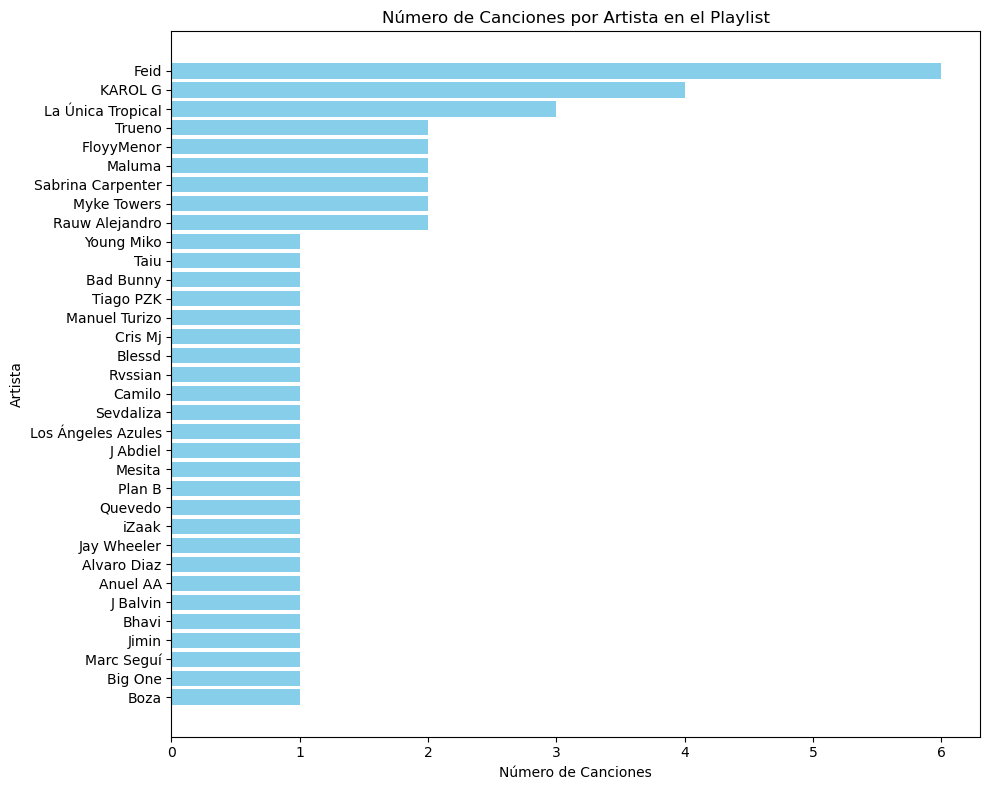

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

def analizar_canciones_y_graficar(canciones):
	artistas = [cancion['artista'] for cancion in canciones]
	conteo_artistas = Counter(artistas)
	
	# Convertir el conteo en un DataFrame de pandas para facilitar la visualización
	df = pd.DataFrame(list(conteo_artistas.items()), columns=['Artista', 'Número de Canciones'])
	
	# Ordenar los datos por el número de canciones
	df = df.sort_values(by='Número de Canciones', ascending=True)
	
	# Crear un gráfico de barras horizontal
	plt.figure(figsize=(10, 8))
	plt.barh(df['Artista'], df['Número de Canciones'], color='skyblue')
	plt.xlabel('Número de Canciones')
	plt.ylabel('Artista')
	plt.title('Número de Canciones por Artista en el Playlist')
	plt.tight_layout()
	plt.show()

# Asegúrate de tener un token válido y el ID correcto del playlist
# Ejemplo de uso
playlist_id = "37i9dQZEVXbJfdy5b0KP7W"  # Asegúrate de usar el ID correcto del playlist
canciones = obtener_canciones_playlist(token, playlist_id)
if canciones:
	analizar_canciones_y_graficar(canciones)
else:
	print("No se pudieron obtener las canciones del playlist.")

In [120]:
import requests
from collections import Counter, defaultdict

def obtener_canciones_playlist(token, playlist_id):
	url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
	headers = {"Authorization": f"Bearer {token}"}
	response = requests.get(url, headers=headers)
	
	if response.status_code == 200:
		data = response.json()
		canciones = []
		for item in data['items']:
			track = item['track']
			canciones.append({
				"nombre": track['name'],
				"artista": track['artists'][0]['name'],  # Tomando el primer artista
				"artista_id": track['artists'][0]['id']  # Incluyendo el ID del artista
			})
		return canciones
	else:
		return None

def obtener_generos_artistas(token, artistas_ids):
	generos = []
	headers = {"Authorization": f"Bearer {token}"}
	for artista_id in artistas_ids:
		url = f"https://api.spotify.com/v1/artists/{artista_id}"
		response = requests.get(url, headers=headers)
		if response.status_code == 200:
			data = response.json()
			generos.extend(data['genres'])
	return generos

def analizar_canciones(canciones, token):
	artistas_ids = list(set([cancion['artista_id'] for cancion in canciones]))  # Eliminar duplicados
	generos = obtener_generos_artistas(token, artistas_ids)
	
	conteo_generos = Counter(generos)
	print("Número de canciones por género en el playlist:")
	for genero, conteo in conteo_generos.items():
		print(f"{genero}: {conteo}")

# Ejemplo de uso 
playlist_id = "37i9dQZEVXbJfdy5b0KP7W"  # Reemplaza esto con el ID real del playlist
canciones = obtener_canciones_playlist(token, playlist_id)
if canciones:
	analizar_canciones(canciones, token)
else:
	print("No se pudieron obtener las canciones del playlist.")

Número de canciones por género en el playlist:
reggaeton: 14
urbano latino: 22
trap argentino: 5
trap latino: 19
latin pop: 3
reggaeton colombiano: 6
trap boricua: 2
argentine hip hop: 2
bases de freestyle: 1
rap canario: 1
k-pop: 1
colombian pop: 3
latin viral pop: 1
puerto rican pop: 1
reggaeton flow: 2
cumbia peruana: 1
mambo chileno: 1
urbano chileno: 1
trap triste: 1
spanish pop: 1
alternative r&b: 1
escape room: 1
persian electronic: 1
pop: 1
gruperas inmortales: 1
musica mexicana: 1
nu-cumbia: 1
ranchera: 1
tropical: 1
panamanian pop: 1
pop reggaeton: 1
rap uruguayo: 1
reggaeton chileno: 1


In [126]:
import requests
import pandas as pd
from collections import Counter, defaultdict

def obtener_canciones_playlist(token, playlist_id):
	url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
	headers = {"Authorization": f"Bearer {token}"}
	response = requests.get(url, headers=headers)
	
	if response.status_code == 200:
		data = response.json()
		canciones_data = []
		for item in data['items']:
			track = item['track']
			canciones_data.append({
				"nombre": track['name'],
				"artista": track['artists'][0]['name'],
				"artista_id": track['artists'][0]['id'],
				"popularidad": track['popularity']  # Incluir la popularidad de la canción
			})
		canciones_df = pd.DataFrame(canciones_data)
		return canciones_df
	else:
		return None

def obtener_generos_artistas(token, artistas_ids):
	generos = []
	headers = {"Authorization": f"Bearer {token}"}
	for artista_id in artistas_ids:
		url = f"https://api.spotify.com/v1/artists/{artista_id}"
		response = requests.get(url, headers=headers)
		if response.status_code == 200:
			data = response.json()
			generos.extend(data['genres'])
	return generos

def analizar_canciones(canciones_df, token):
	artistas_ids = list(set(canciones_df['artista_id']))
	generos = obtener_generos_artistas(token, artistas_ids)
	
	conteo_generos = Counter(generos)
	print("Número de canciones por género en el playlist:")
	for genero, conteo in conteo_generos.items():
		print(f"{genero}: {conteo}")

	# Nuevo: Analizar y mostrar las canciones más populares
	canciones_populares = canciones_df.sort_values(by='popularidad', ascending=False).head(10)
	print("\nTop 10 canciones más populares:")
	print(canciones_populares[['nombre', 'artista', 'popularidad']])

# Ejemplo de uso 
playlist_id = "37i9dQZEVXbJfdy5b0KP7W"  # Reemplaza esto con el ID real del playlist
canciones_df = obtener_canciones_playlist(token, playlist_id)
if canciones_df is not None:
	analizar_canciones(canciones_df, token)
else:
	print("No se pudieron obtener las canciones del playlist.")



Número de canciones por género en el playlist:
reggaeton: 14
urbano latino: 22
trap argentino: 5
trap latino: 19
latin pop: 3
reggaeton colombiano: 6
trap boricua: 2
argentine hip hop: 2
bases de freestyle: 1
rap canario: 1
k-pop: 1
colombian pop: 3
latin viral pop: 1
puerto rican pop: 1
reggaeton flow: 2
cumbia peruana: 1
mambo chileno: 1
urbano chileno: 1
trap triste: 1
spanish pop: 1
alternative r&b: 1
escape room: 1
persian electronic: 1
pop: 1
gruperas inmortales: 1
musica mexicana: 1
nu-cumbia: 1
ranchera: 1
tropical: 1
panamanian pop: 1
pop reggaeton: 1
rap uruguayo: 1
reggaeton chileno: 1

Top 10 canciones más populares:
                                        nombre            artista  popularidad
33                                    Espresso  Sabrina Carpenter          100
26                        Please Please Please  Sabrina Carpenter           98
3                                    Gata Only         FloyyMenor           96
0                            REAL GANGSTA LOVE 

NameError: name 'data' is not defined